# MCMCのなかをのぞいてみよう
## 例題：混合モデルの教師無しクラスタリング


In [2]:
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXt6b", "data/miture_data.csv")

('data/miture_data.csv', <http.client.HTTPMessage at 0x22515b05828>)

In [3]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
figsize(12.5, 4)


(array([  3.,   2.,   6.,   9.,  15.,  17.,  15.,  19.,  12.,  16.,  15.,
         31.,  32.,  40.,  31.,  24.,  10.,   2.,   0.,   1.]),
 array([  47.40688607,   58.916721  ,   70.42655594,   81.93639088,
          93.44622581,  104.95606075,  116.46589569,  127.97573062,
         139.48556556,  150.99540049,  162.50523543,  174.01507037,
         185.5249053 ,  197.03474024,  208.54457518,  220.05441011,
         231.56424505,  243.07407999,  254.58391492,  266.09374986,
         277.60358479]),
 <a list of 1 Patch objects>)

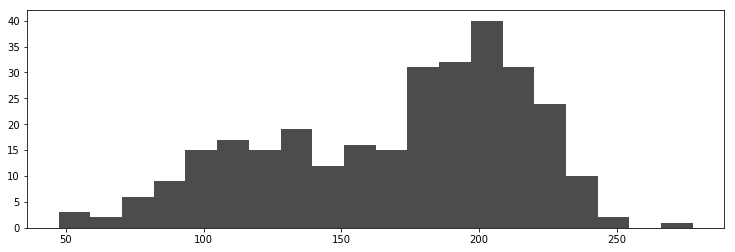

In [6]:
data = np.loadtxt("data/miture_data.csv", delimiter=",")
plt.hist(data, bins=20, color='k', histtype="stepfilled", alpha=0.7)

- 各データ点について、確率pでクラスタ0を選択する。クラスタ0を選択しなければクラスタ1を選択する。
- パラメータ $\mu_i$ と $ \sigma_i $ の正規分布から値を一つサンプリングする。
- 繰り返す

In [30]:
import pymc as pm
p = pm.Uniform("p", 0, 1.)
assignment = pm.Categorical("assignment", [p, 1-p], size=data.shape[0])
taus = 1.0 / pm.Uniform("stds", 0, 33, size=2) ** 2
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

observation = pm.Normal("obs", center_i, tau_i, value=data, observed=True)
model = pm.Model([p, assignment, taus, centers])


In [31]:
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 17.9 sec

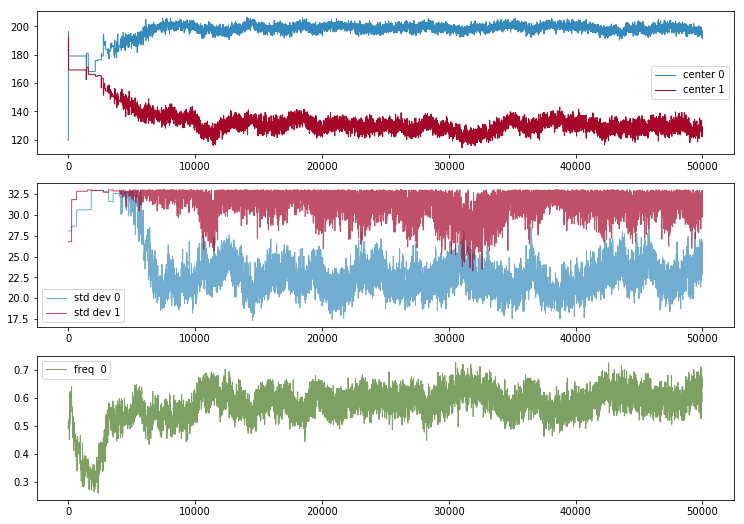

In [32]:
figsize(12.5, 9)
line_width = 1

colors = ["#348ABD", "#A60628"]
center_trace = mcmc.trace("centers")[:]
if center_trace[-1, 0] < center_trace[-1,1]:
    colors =  ["#A60628", "#348ABD"]

plt.subplot(311)
plt.plot(center_trace[:, 0], label="center 0", c=colors[0], lw=line_width)
plt.plot(center_trace[:, 1], label="center 1", c=colors[1], lw=line_width)
plt.legend()

plt.subplot(312)
std_trace=mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="std dev 0", c=colors[0], lw=line_width, alpha=0.7)
plt.plot(std_trace[:, 1], label="std dev 1", c=colors[1], lw=line_width, alpha=0.7)
plt.legend()

plt.subplot(313)
p_trace=mcmc.trace("p")[:]
plt.plot(p_trace, label="freq  0", c="#467821", lw=line_width, alpha=0.7)
plt.legend()


- 軌跡は収束するが、ある一点ではなくある分布に収束する。これがMCMCアルゴリズムの収束である。
- 最初の数千点は推論には使えない。この期間をバーンイン(burn-in)と呼ぶ
- 軌跡はランダムウォークのように見える。

## クラスタを求める

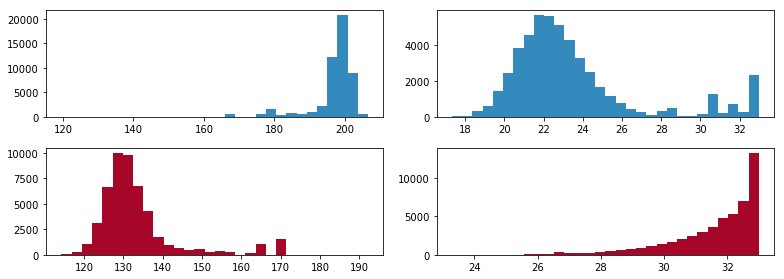

In [35]:
figsize(11.0, 4)
std_trace=mcmc.trace("stds")[:]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2*i])
    plt.hist(center_trace[:,i], color=colors[i], bins=30, histtype="stepfilled")
    plt.subplot(2, 2, _i[2*i+1])
    plt.hist(std_trace[:,i], color=colors[i], bins=30, histtype="stepfilled")

plt.tight_layout()